<a href="https://colab.research.google.com/github/tom-youngblood/cnn-selfie-recognition/blob/main/cnn_person_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network Project: Selfie Facial Recognition and Real World Generalization
by Tom Youngblood

# Problem Statement

This project aims to develop a deep learning model, trained on selfies, that can accurately generalize to real-world, non-selfie images of same individuals.

**The Problem that This Project Solves**: Rapidly employable facial recognition with training data from the most readily available source of facial data: selfies.

**Why Deep Learning?**: Deep Learning and Convolutional Neural Networks (CNNs), such as the models employed in this project, are well suited for this task, as they are the industry standard for computer vision tasks like image classification.

This project explores how well a Convolutional Neural Network trained on a controlled set of selfies can generalize to unconstrained, real world settings.

In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Problem Set Up
**Model Inputs**: The inputs and outputs of the initial deep learning model (VGG16) can be found below:

<table>
  <tr>
    <th>Variable</th>
    <th>Type</th>
    <th>Range</th>
    <th>Encoding</th>
  </tr>
  <tr>
    <td>Image</td>
    <td>RGB Image</td>
    <td>224x224x3</td>
    <td>Normalized (Rescaled: 1./255)</td>
  </tr>
  <tr>
    <td>Person Label</td>
    <td>Categorical</td>
    <td>5 people</td>
    <td>Sparse categorical</td>
  </tr>
  <tr>
    <td>Image Type</td>
    <td>Categorical</td>
    <td>Selfie, Non-Selfie</td>
    <td>Normalized (Rescaled: 1./255)</td>
  </tr>
</table>

# Problem Exploration
## Data Cleaning and Collection
Data cleaning for this project was very time consuming and could not easily be completed with programming. Therefore, data cleaning was completed outside of this notebook. Techniques employed:

1. Collecting images from individuals and filtering out unusable photos.
2. Bulk assigning images of each class (individuals) to respective folders in Google Drive; ensuring file structure compatibility with tensorflow/keras.
3. Mass converting images from .HEIC (standard iPhone camera file format in certain settings; incompatible with TF/Keras) to .JPEG or .PNG.
  - Before converting, many photos were not readable by Tensorflow/Keras natively. As each person contributing photos had a different phone model and sent the images through a different medium, certain individuals provided only unreadable .HEIC images (100+), causing massive class imbalances before data cleanup/conversion.

Unexpectedly, data cleaning took a large majority of the project's time resources due to unforseen file incompatibilities.

## Data Bias
**Class Imbalance**: There was a stark difference in performance before and after balancing classes through data-cleanup.

**Initial Training Data Bias**: The model is expected to fit better on the initial controlled training data/validation data than the general real world images due to a variety of factors:

- Consistent lighting
- Consistent camera angle
- Consistent person age/appearence
- Single person photos

# Neural Network Implementation

## Loading Data

### Connecting to Google Drive.

In [ ]:
# Mount drive
drive.mount("/content/drive")

# Dataset path
path = "/content/drive/MyDrive/Colab Notebooks/cnn_images"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Number of images per class
for person in os.listdir(path):
  person_path = os.path.join(path, person)
  num_images = len(os.listdir(person_path))
  print(f"Class: {person}: {num_images} images")

Class: Issy: 113 images
Class: Oliver: 141 images
Class: Ryan: 100 images
Class: Sam: 104 images
Class: Tom: 86 images


### Loading data from Google Drive folders.

In this section, data from Google Drive folders is passed to data generators, which vectorize them in a format readable by TF/Keras.

In [ ]:
# Establish image size and batch size
image_size = (224, 224)
batch_size = 32

**Image Size 224x224**: Standard input image size for CNNS such as those used in this project (ex: VGG16).

**Batch Size 32**: Commonly used batch size for image detection models.

### Data Generation

In [ ]:
# Establish datagen with normalization and 20% validation split, and data augmentations
train_datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest"
                             )

The **Data Generator** above creates rescaled images with, reserving 20% of images for validation data. Multiple data augmentations are made to expand the data.

In [ ]:
# Train image generator: from google drive folders
train_gen = train_datagen.flow_from_directory(directory=path,
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        class_mode="sparse",
                                        subset="training",
                                        interpolation="nearest"
)

Found 436 images belonging to 5 classes.


In [ ]:
validation_gen = train_datagen.flow_from_directory(directory=path,
                                                   target_size=image_size,
                                                   batch_size=batch_size,
                                                   class_mode="sparse",
                                                   subset="validation",
                                                   interpolation="nearest"
    )

Found 107 images belonging to 5 classes.


**Training Data**: Almost 100 selfies per class.

**Validation Data**: ~20 selfies per class.

## Initial Pre-Trained Model: VGG16

In this section, VGG16, a pre-trained image recognition model, is loaded in and tested on the dataset.

### Configuring VGG16

In [ ]:
# Load VGG16, no top layers, pre-trained image-net weights
model_VGG16_base = VGG16(weights="imagenet",
                         include_top=False,
                         input_shape=(224, 224, 3)
                         )

Shape = 224, 224, 3: Number of pixels, 3 color channels.

In [ ]:
# Freeze base layers
for layer in model_VGG16_base.layers:
  layer.trainable=False

The base layers are frozen to prevent retraining the model.

In [ ]:
# Add Custom classifier
x = model_VGG16_base.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(units=5, activation="softmax")(x)

Dropout included to aid in generalization.

In [ ]:
# VGG16 model 1
model_VGG16_1 = Model(inputs=model_VGG16_base.input,
                      outputs=output_layer
                      )

Custom classifier and output layer are added to the final model.

### Compiling Model

In [ ]:
# Compile VGG16 Model 1
model_VGG16_1.compile(optimizer="adam",
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
                      )

### Fitting Model

In [ ]:
def make_callback(model_name):
  # Define checkpoit filepath
  path = os.path.join("checkpoints", f"{model_name}.keras")

  # Early stopping params
  callbacks_list = [
      EarlyStopping(
          monitor='val_accuracy',
          patience=3,
          restore_best_weights=True
        ),
      ModelCheckpoint(
          filepath=path,
          monitor="val_loss",
          save_best_only=True
      )
  ]
  return callbacks_list

In [ ]:
# Fit VGG16 Model 1
history_model_VGG16_1 = model_VGG16_1.fit(x=train_gen,
                                          epochs=10,
                                          callbacks=make_callback("model_VGG16_1"),
                                          validation_data=validation_gen
                                          )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3013 - loss: 4.7760 - val_accuracy: 0.9252 - val_loss: 0.4029
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8407 - loss: 0.4826 - val_accuracy: 1.0000 - val_loss: 0.0877
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9314 - loss: 0.2447 - val_accuracy: 1.0000 - val_loss: 0.0494
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9669 - loss: 0.1510 - val_accuracy: 1.0000 - val_loss: 0.0544
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9792 - loss: 0.0993 - val_accuracy: 1.0000 - val_loss: 0.0157


Fit using 10 epochs. Initial learnings:
- Extremely high accuracy
- Extremely high validation accuracy

In [ ]:
# Save model
save_model(model_VGG16_1, "/content/drive/MyDrive/Colab Notebooks/models/model_VGG16_1.keras")

In [ ]:
# Retrieve best model
best_model_VGG16_1 = load_model("/content/drive/MyDrive/Colab Notebooks/models/model_VGG16_1.keras")

### Model Performance

#### VGG16: Loss vs. Accuracy

In [ ]:
# Function for plotting model
def plot_metrics_epoch(history_data):
    fig, axs = plt.subplots()

    axs.plot(history_data.epoch, history_data.history['accuracy'], label='Training Accuracy', color='blue')
    axs.plot(history_data.epoch, history_data.history['loss'], label='Training Loss', color='blue', linestyle='dotted')
    axs.plot(history_data.epoch, history_data.history['val_accuracy'], label="Validation Accuracy", color='red')
    axs.plot(history_data.epoch, history_data.history['val_loss'], label="Validation Loss", color='red', linestyle='dotted')

    axs.set_title('Metric by Epoch')
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Metric')

    plt.legend(loc='best')

    fig.tight_layout()
    plt.show()

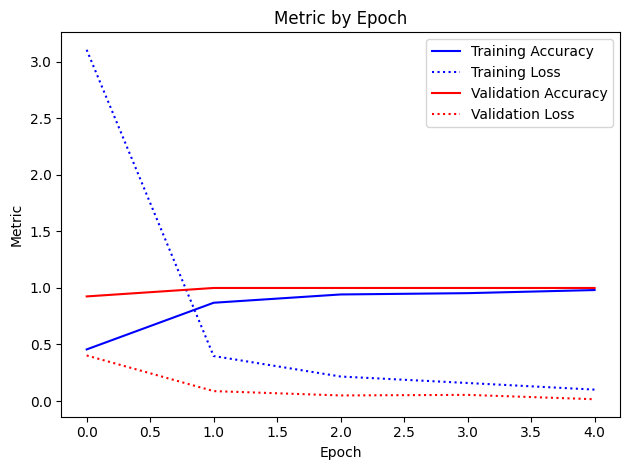

In [ ]:
plot_metrics_epoch(history_model_VGG16_1)

**Selfie Performance**: Model performed extremely well on selfie data, predicting 100% validation accuracy and 97.8% general accuracy. The model does not seem to be overfitting, as the training and validation metrics are nearly identical by the fourth epoch.

#### VGG16: Sample of 10 Predictions vs Labels

In [ ]:
def plot_images(model, images, labels):

  # Make predictions on images and labels
  pred_images = model.predict(images)
  pred_labels = np.argmax(pred_images, axis=1)
  real_labels = labels
  label_names = ["Issy", "Oliver", "Ryan", "Sam", "Tom"]

  # Set up plot
  fig, axes = plt.subplots(1,10, figsize=(15,5))
  axes= axes.flatten()

  # Iterate through images, plot each
  for i in range(len(axes)):
    axes[i].imshow(images[i])

    # Title plots based on their predicted vs actuals
    axes[i].set_title(f"Predicted: {label_names[pred_labels[i]]}\nActual: {label_names[int(real_labels[i])]}")

    # Remove ticks
    axes[i].axis('off')

  # Plot
  plt.tight_layout()
  plt.show()

In [ ]:
# Get images and labels
images, labels = next(validation_gen)

Below are examples of the model's predictions on selfie data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


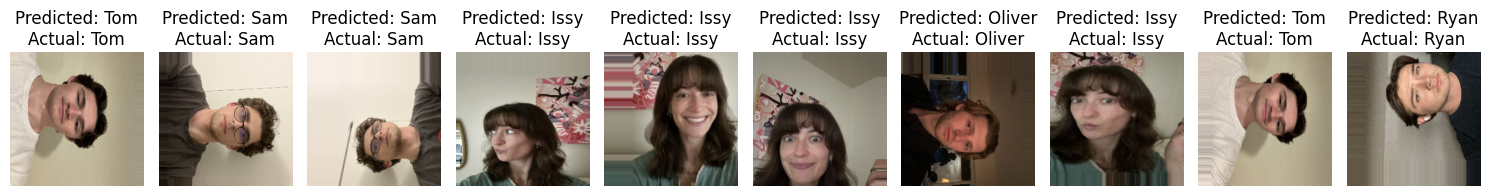

In [ ]:
plot_images(best_model_VGG16_1, images, labels)

The model clearly predicts on the validation set very well.

**Next Step -- Generalization**: The next step is to test how the model generalizes on unseen, real-world images.

## Generalizing VGG16 Model to Non-Selfies


### Loading Data
In the code below, non-selfie data is loaded from a newly created Google Drive folder and rescaled to the same format as the training data. This data will be used to test how the model generalizes.

In [ ]:
# Test data path
test_path = "/content/drive/MyDrive/Colab Notebooks/cnn_test_images/"

# Test Datage: Rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Number of images per class
for person in os.listdir(test_path):
  person_path = os.path.join(test_path, person)
  num_images = len(os.listdir(person_path))
  print(f"Class: {person}: {num_images} images")

Class: Issy: 10 images
Class: Ryan: 10 images
Class: Tom: 10 images
Class: Oliver: 10 images
Class: Sam: 10 images


In [ ]:
# Load Test Data
test_gen = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

Found 50 images belonging to 5 classes.


### Predicting on Unseen, Real-World Data

In [ ]:
# Predictions
predictions = best_model_VGG16_1.predict(test_gen)
pred_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_gen.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


### VGG16 Model 1: Performance of Generalization to Unseen, Real World Data

#### Accuracy Score

In [ ]:
# Accuracy score
accuracy_score(true_labels, pred_labels)

0.44

**Accuracy Score**: The model produced 44% accuracy on unseen data in real-world scenarios. Therefore, the model predicts 24% better than random chance (1/5). The highest accuracy recived from the model was 50%, on previous runs.

#### Confusion matrix

In [ ]:
# Plot confusion matrix
def plot_cm(true_labels, pred_labels, test_gen):
  cm = confusion_matrix(true_labels, pred_labels)
  plt.figure()
  sns.heatmap(cm,
              annot=True,
              xticklabels=list(test_gen.class_indices.keys()),
              yticklabels=list(test_gen.class_indices.keys()))
  plt.xlabel("Predicted Label")
  plt.ylabel("Real Label")
  plt.title("Confusion Matrix: VGG16 Model 1 Performance")
  plt.show()

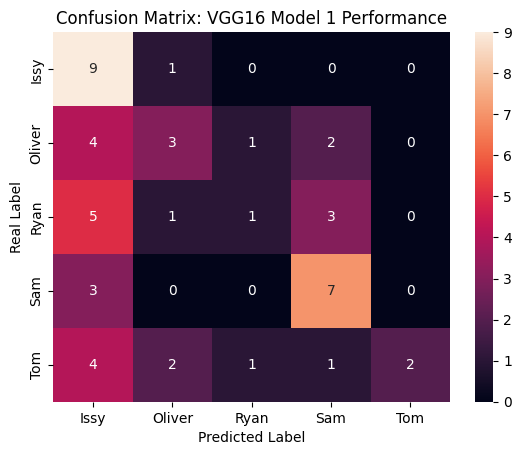

In [ ]:
plot_cm(true_labels, pred_labels, test_gen)

**Detailed Performance Review with Confusion Matrix**:

- The model biases making predictions towards Issy, Oliver, and Sam.
- Before re-runs, the model originally predicted:
  - Issy: 19 predictions. 47% accuracy.
  - Oliver: 20 predictions. 40% accuracy.
  - Ryan: 0 predictions. 0% accuracy.
  - Sam: 10 predictions. 80% accuracy.
  - Tom: 1 prediction: 0% accuracy
  - The model is heavily biased against predicting Ryan (0 predictions) and Tom (1 prediction).

**Reception of the first model**: Overal, I'm very impressed with how the model generalized, having been trained on selfies alone.

**Initial Ideas for Model Improvement -- Class Imbalance**: The model may be over-predicting Issy and Oliver due to class imbalance, which would make sense:

- Class: Issy: 113 images
- Class: Oliver: 141 images
- Class: Tom: 86 images
- Class: Sam: 104 images
- Class: Ryan: 100 image

**Additional Idea for Model Improvement -- Unfreezing Layers**: It's possible that the VGG16 model is relying too much on pre-trained image-net weights. Unfreezing the final layers of the model and retraining could improve this.



#### Example Predictions

A subset of the class' predictions on real-world images are visible on a subset below.

In [ ]:
# Get images and labels
images, labels = next(test_gen)

In [ ]:
# Shuffle images and labels
indices = np.arange(len(images))
np.random.shuffle(indices)
shuffled_images = images[indices]
shuffled_labels = labels[indices]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


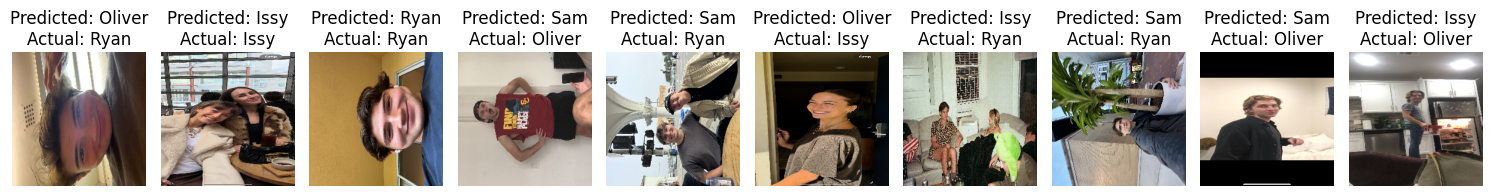

In [ ]:
plot_images(best_model_VGG16_1, shuffled_images, shuffled_labels)

# Further Optimizing VGG16 Model

In this section, the VGG16 Model is optimized by accounting for:
- **Class Imbalancee**
- **Training image homogeneity**
- **Reliance on pre-trained image-net weights**

Firstly, in "Training Data Augmentation", the issues of class imbalance and training image homogeneity are tackled.

## Training Data Augmentation

New folders were created in Google Drive, each holding 100 images of each class.

New data generators were created below, which control for:

- Class imbalance
- Training image homogeneity (over-similarity between training images within classes)

In [ ]:
# New Train Datagen
train_datagen_2 = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2,
                                     rotation_range=45,
                                     width_shift_range=0.3,
                                     height_shift_range=0.3,
                                     brightness_range=[0.9, 1.1],
                                     shear_range=0.4,
                                     zoom_range=0.3,
                                     vertical_flip=True,
                                     horizontal_flip=True,
                                     fill_mode="nearest"
                             )

Data augmentation increased; added:

- Brightness Range
- Vertical Flip
- Increased all augmentations by 0.1

In [ ]:
# Dataset path
path = "/content/drive/MyDrive/Colab Notebooks/cnn_train_images_2"

In [ ]:
# Number of images per class
for person in os.listdir(path):
  person_path = os.path.join(path, person)
  num_images = len(os.listdir(person_path))
  print(f"Class: {person}: {num_images} images")

Class: Issy: 100 images
Class: Oliver: 100 images
Class: Ryan: 100 images
Class: Sam: 100 images
Class: Tom: 100 images


As seen above, the number of images from Oliver, Issy, and Sam were reduced. Tom's number of images was increased by 14. Now, all classes have the same number of images.

In [ ]:
# Train image generator: from google drive folders
train_gen_2 = train_datagen_2.flow_from_directory(directory=path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="sparse",
                                                  subset="training",
                                                  interpolation="nearest"
)

Found 400 images belonging to 5 classes.


In [ ]:
validation_gen_2 = train_datagen.flow_from_directory(directory=path,
                                                     target_size=image_size,
                                                     batch_size=batch_size,
                                                     class_mode="sparse",
                                                     subset="validation",
                                                     interpolation="nearest"
    )

Found 100 images belonging to 5 classes.


As seen above, there is now a perfect 400 by 100 train-validation split (20% validation), controlling for class imbalances.

## Retraining Model: Data Augmentation

In the code below, the model is retrained with the new, augmented and re-balanced data.

In [ ]:
# Load New Base Model
model_VGG16_base_2 = VGG16(weights="imagenet",
                         include_top=False,
                         input_shape=(224, 224, 3)
                         )

In [ ]:
# Freeze layers
for layer in model_VGG16_base_2.layers:
  layer.trainable = False

In [ ]:
# Add Custom classifier
x = model_VGG16_base_2.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(units=5, activation="softmax")(x)

In [ ]:
# VGG16 model 2
model_VGG16_2 = Model(inputs=model_VGG16_base_2.input,
                      outputs=output_layer
                      )

In [ ]:
# Compile VGG16 Model 2
model_VGG16_2.compile(optimizer="adam",
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
                      )

In [ ]:
# Fit VGG16 Model 2
history_model_VGG16_2 = model_VGG16_2.fit(x=train_gen_2,
                                          epochs=10,
                                          callbacks=make_callback("model_VGG16_2"),
                                          validation_data=validation_gen_2
                                          )

# Save model
save_model(model_VGG16_2, "/content/drive/MyDrive/Colab Notebooks/models/model_VGG16_2.keras")

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 11s/step - accuracy: 0.2590 - loss: 4.5720 - val_accuracy: 0.4200 - val_loss: 1.3495
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4493 - loss: 1.4353 - val_accuracy: 0.9200 - val_loss: 0.6361
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.6392 - loss: 0.9650 - val_accuracy: 0.9800 - val_loss: 0.3198
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8302 - loss: 0.6775 - val_accuracy: 0.9900 - val_loss: 0.2428
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7572 - loss: 0.6935 - val_accuracy: 1.0000 - val_loss: 0.1822
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8307 - loss: 0.5249 - val_accuracy: 1.0000 - val_loss: 0.1410
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8750 - loss: 0.4852 - val_accuracy: 0.9900 - val_loss: 0.1334
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8540 - loss: 0.4548 - val_accuracy: 1.0000 - val_los

As seen in the 8 epochs above, the accuracy of the model was reduced when trained on further augmented and balanced data.

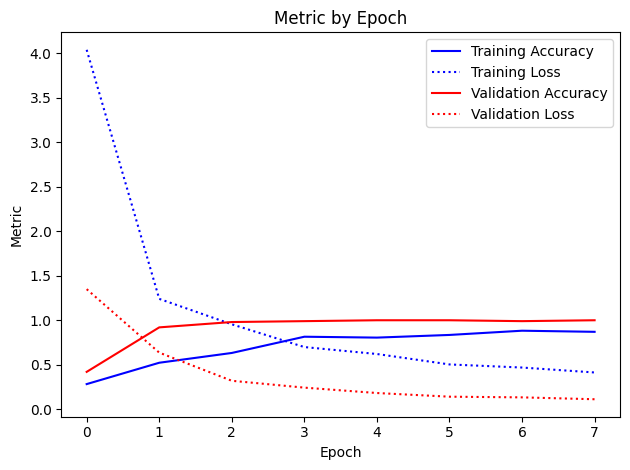

In [ ]:
plot_metrics_epoch(history_model_VGG16_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


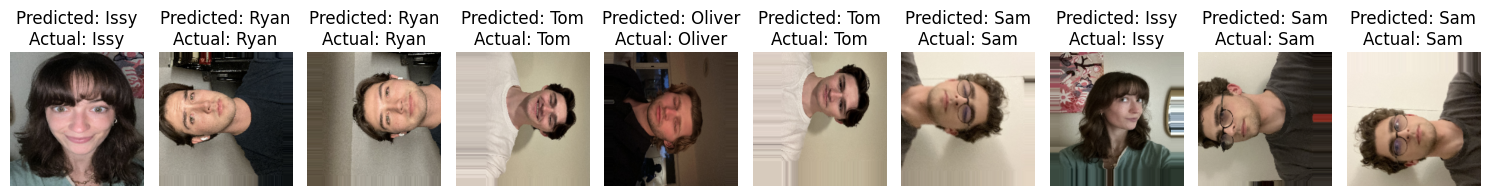

In [ ]:
# Example selfies images
images, labels = next(validation_gen_2)
plot_images(model_VGG16_2, images, labels)

As seen by the predictions above, the VGG16_2 model performed worse on the selfie data. It's performance on the real-world data is outlined below.

## VGG16, Model 2 -- Increased Data Augmentation: Predictions on Real-World Data

In [ ]:
# Predictions
predictions = model_VGG16_2.predict(test_gen)
pred_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_gen.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


In [ ]:
# Accuracy score
accuracy_score(true_labels, pred_labels)

0.4

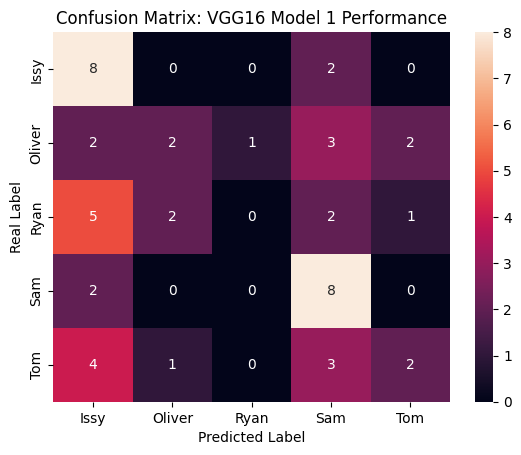

In [ ]:
plot_cm(true_labels, pred_labels, test_gen)

On the real-world images, the model produced 10% lower accuracy score than the initial VGG16 model. Therefore, the following modifications to the model will be performed using the original data generators.

Additionally, overall class imbalance was proportionally decreased. Although, Ryan and Tom still have have noticably lower predictions than the other classes.

## Retraining VGG16 Model: Reduction of Reliance on Pre-Trained Weights

In this section the hypothesis and potential solution seen below are explored.

**Hypothesis**: The VGG16 model's pre-trained weights may be partially responsible for poor generalization (50% accuracy) from selfies to real-world images. The model may be overfitting to these pre-trained weights.

**Potential Solution**: Un-freeze the final 10 layers of the model.

In [ ]:
# Load New Base Model
model_VGG16_base_3 = VGG16(weights="imagenet",
                         include_top=False,
                         input_shape=(224, 224, 3)
                         )

In [ ]:
# Un-Freeze the final 10 layers
for layer in model_VGG16_base_3.layers:
  layer.trainable = False

for layer in model_VGG16_base_3.layers[-10:]:
  layer.trainable = True

In [ ]:
# Add Custom classifier
x = model_VGG16_base_3.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(units=5, activation="softmax")(x)

In [ ]:
# VGG16 model 3
model_VGG16_3 = Model(inputs=model_VGG16_base_3.input,
                      outputs=output_layer
                      )

In [ ]:
# Compile VGG16 Model 2
model_VGG16_3.compile(optimizer="adam",
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
                      )

In [ ]:
# Fit VGG16 Model 3 (Original Training and Validation Data)
history_model_VGG16_3 = model_VGG16_3.fit(x=train_gen,
                                          epochs=10,
                                          callbacks=make_callback("model_VGG16_3"),
                                          validation_data=validation_gen
                                          )

# Save model
save_model(model_VGG16_3, "/content/drive/MyDrive/Colab Notebooks/models/model_VGG16_3.keras")

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.2228 - loss: 3.7712 - val_accuracy: 0.2243 - val_loss: 1.6101
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.2094 - loss: 1.6238 - val_accuracy: 0.2617 - val_loss: 1.5769
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2706 - loss: 1.5915 - val_accuracy: 0.2617 - val_loss: 1.6004
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2252 - loss: 1.6416 - val_accuracy: 0.2617 - val_loss: 1.5975
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2712 - loss: 1.5977 - val_accuracy: 0.2243 - val_loss: 1.6105


As seen above, re-adjusting the weights caused accuracy to drop dramatically to a peak of 27%. This informed the decision-making in the following models, which use the original image-net weights.

Following this section, I researched learning rate with pre-trained models and learned that it has can have a large impact on their weights.

## Retraining VGG16 Model: Learning Rate Scheduling

This section tackles the hypothesis and potential solution regarding learning rates below.

**Hypothesis**: A static learning rate can ruin the effectiveness of a pre-trained model's features.

**Potential Solution**: Learning rate scheduling may increase the effectiveness of these features.

In the code below, the original (thus far, most successful) model is re-compiled and re-trained using a scheduled learning rate.

In [ ]:
# Reduce learning rate
model_VGG16_1.compile(optimizer=Adam(learning_rate=0.001),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

The initial learning rate is reduced...

In [ ]:
# Schedule learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=1,
                                 min_lr=0.0001)

...and a learning rate scheduler is implemented with a minimum learning rate of 0.0001.

In [ ]:
# Refit VGG16 Model 1 with learning rate scheduler
history_model_VGG16_1_lrscheduler = model_VGG16_1.fit(train_gen,
                                                      epochs=10,
                                                      validation_data=validation_gen,
                                                      callbacks=[lr_scheduler]
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.2390 - loss: 1.6008 - val_accuracy: 0.2617 - val_loss: 1.5961 - learning_rate: 0.0010
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2674 - loss: 1.5945 - val_accuracy: 0.2617 - val_loss: 1.5960 - learning_rate: 0.0010
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2289 - loss: 1.6070 - val_accuracy: 0.2617 - val_loss: 1.5960 - learning_rate: 5.0000e-04
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2842 - loss: 1.5887 - val_accuracy: 0.2617 - val_loss: 1.5960 - learning_rate: 2.5000e-04
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2720 - loss: 1.5936 - val_accuracy: 0.2617 - val_loss: 1.5960 - learning_rate: 2.5000e-04
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2829 - loss: 1.5897 - val_accuracy: 0.2617 - val_loss: 1.5959 - learning_rate: 1.2500e-04
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.2744 - loss: 1.5934 

After training, learning rate scheduling lead to very poor performance. As model complexity is not an issue, and learning rate is not an issue, I assume that that data itself is likely an issue.

Below, I delve further into data manipulation in efforts to optimize the model's performance with the data available.

# Data Manipulation: Cropping Faces

This section tests the hypothesis below and uses a modified version of the original data.

**Hypothesis**: Cropping faces using cv2 can reduce the model's interpretation of backgrounds, ensuring that it solely focuses on faces.

**Potential Solution**: Duplicating the original dataset of images, cropping images with cv2, re-predicting on new images.

A duplicate version of the original file structure was manially created in Google Drive, "cnn_images_cropped". Below, a facial recognition model is installed, and the images in the google drive folders mentioned are cropped to only include faces.

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml

--2025-03-09 21:32:15--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540616 (528K) [text/plain]
Saving to: ‘haarcascade_frontalface_alt2.xml’

haarcascade_frontal 100%[===================>] 527.95K  --.-KB/s    in 0.005s  

2025-03-09 21:32:15 (98.8 MB/s) - ‘haarcascade_frontalface_alt2.xml’ saved [540616/540616]



## Facial Cropping

In this sub-section, all training images are modified to only include the individual's face.

In [ ]:
def convert_image_to_face(image_path):
  # Read image
  image = cv2.imread(image_path)

  # Convert to greyscale
  gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Load cascade classifier
  cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

  # Detect Face within cascade
  faces = cascade.detectMultiScale(gray_scale, 1.1, 4)

  # Crop face if exists
  if len(faces):
    x, y, w, h = faces[0]
    cv2.imwrite(image_path, image[y:y+h, x:x+w])

In [ ]:
# Establish directory path
directory_path = "/content/drive/MyDrive/Colab Notebooks/cnn_images_cropped"

In [ ]:
# Iterate through folders within root directory
for root, folder, images in os.walk(directory_path):
  # Iterate through each image
  for image in images:
    # Check if image is readable
    if image.lower().endswith(('.png', '.jpg', '.jpeg')):
      # Crop image
      convert_image_to_face(os.path.join(root, image))

## Retrain VGG16 Model 1 on Cropped Faces

The data-generators are then modified to take the new, modified images.

In [ ]:
# Train image generator: from google drive folders
train_gen_cropped = train_datagen.flow_from_directory(directory=directory_path,
                                                      target_size=image_size,
                                                      batch_size=batch_size,
                                                      class_mode="sparse",
                                                      subset="training",
                                                      interpolation="nearest"
)

validation_gen_cropped = train_datagen.flow_from_directory(directory=directory_path,
                                                           target_size=image_size,
                                                           batch_size=batch_size,
                                                           class_mode="sparse",
                                                           subset="validation",
                                                           interpolation="nearest"
    )

Found 429 images belonging to 5 classes.
Found 106 images belonging to 5 classes.


And finally, the model is re-trained on the images.

In [ ]:
# Adjusted output layer
x = model_VGG16_base.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer_cropped = Dense(units=5, activation="softmax")(x)

# VGG16 Cropped Model
model_VGG16_cropped = Model(inputs=model_VGG16_base.input,
                            outputs=output_layer_cropped
                      )

# Compile VGG16 Cropped Model
model_VGG16_cropped.compile(optimizer="adam",
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy']
                            )

# Fit VGG16 Cropped Model
history_model_VGG16_cropped = model_VGG16_cropped.fit(x=train_gen_cropped,
                                          epochs=10,
                                          callbacks=make_callback("model_VGG16_cropped"),
                                          validation_data=validation_gen_cropped
                                          )

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2618 - loss: 5.2219

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2694 - loss: 5.1161 - val_accuracy: 0.6887 - val_loss: 0.7550
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6803 - loss: 0.8251 - val_accuracy: 0.8962 - val_loss: 0.4310
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8217 - loss: 0.5172 - val_accuracy: 0.9245 - val_loss: 0.3027
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8722 - loss: 0.3643 - val_accuracy: 0.9340 - val_loss: 0.2401
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8774 - loss: 0.3540 - val_accuracy: 0.9340 - val_loss: 0.2126
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9226 - loss: 0.2550 - val_accuracy: 0.9340 - val_loss: 0.1807
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9187 - loss: 0.2253 - val_accuracy: 0.9623 - val_loss: 0.1643
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9415 - loss: 0.2020 - val_accuracy: 0.9717 - val_loss: 0.1381
Epo

Training produced very promising results on the selfie images...

## Testing Predictions of Cropped Model

In [ ]:
# Predictions
predictions = model_VGG16_cropped.predict(test_gen)
pred_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_gen.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [ ]:
# Accuracy score
accuracy_score(true_labels, pred_labels)

0.3

...but a reduced accuracy when generalizing to real-world images.

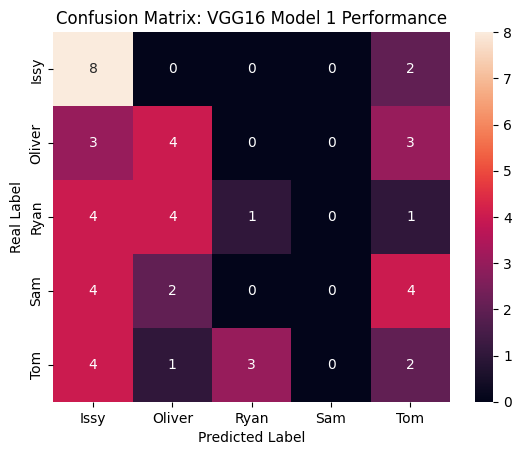

In [ ]:
plot_cm(true_labels, pred_labels, test_gen)

Adjusting the training data unexpectedly had a negative impact on the model's performance, reducing its accuracy by 20%. Interestingly enough, this solution did fix certain class imbalances, but increased others.
- Tom and Ryan now are predicted more often, while Sam is predicted less.

# Conclusion

The base VGG16 model with a simple custom classifier (one dense layer, one dropout layer of 50%) consistently outperformed all other variations. While data cleanup and augmentation were necessary to improve performance, no architectural changes or fine-tuning strategies were able to surpass the initial model’s 50% accuracy on real-world images.

Key findings from model iterations are listed below:
- The initial VGG16 model achieved 100% validation accuracy on selfie images, and generalized to real world images with 50% accuracy (which is 30% better than random chance).
- Increased data augmentation and the elimination of class imbalance unexpectedly hurt model performance, reducing generalization accuracy to 40%.
- Unfreezing 10 ImageNet layers resulted in a significant performance drop (28% training accuracy).
- Adjusting learning rate using a scheduled learning rate similarly provided no-model improvement.
- Training on only cropped faces and removing background noise reduced model generalization accuracy to 30%.

This project was limited by data availability; if time and resources allowed, next steps would involve training different model architectures on larger, more diverse set of data.

In conclusion, the project served as a compelling thought experiment on training Convolutional Neural Networks using small, organic datasets. Furthermore, the project proved that CNNs can generalize well from small, artificial datasets to real-world data with surprising accuracy.